## Weather data visualization

In [2]:
import os
import yaml

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from palettable.colorbrewer.sequential import Purples_9
from palettable.colorbrewer.sequential import GnBu_8
from palettable.colorbrewer.sequential import OrRd_6

from ideotype.data_process import read_sims, read_data, parse_mature

In [3]:
# Read in processed data
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary_control_fixpd.csv', dtype={'site': str})
df_siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_control_fixpd.csv', dtype={'site':str})
df_stations = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', dtype={'USAF': str})

# Create df_sites
df_sites = df_stations[df_stations.USAF.isin(df_siteyears.site)][['USAF', 'NSRDB_LAT (dd)', 'NSRDB_LON(dd)']]
df_sites.columns = ['site', 'lat', 'lon']
df_sites['years'] = list(df_siteyears.groupby('site').count()['year'])

In [4]:
df_wea_grouped = df_wea.groupby('site').mean().reset_index()
df_wea_summary = pd.merge(df_wea_grouped, df_sites, on='site')

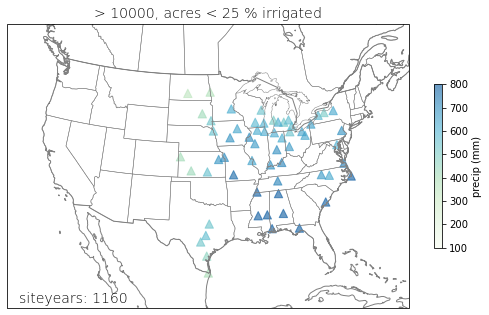

In [14]:
area = 10000/2.47
irri = 25

# Map out simulation sites
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
mp = ax.scatter(df_wea_summary.lon, df_wea_summary.lat,
                transform=ccrs.PlateCarree(), s=70, marker='^',
                c=df_wea_summary.precip, cmap=GnBu_8.mpl_colormap, 
                vmin=100, vmax=800, alpha=0.6)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'> {int(area*2.47)}, acres < {irri} % irrigated',
             fontweight='light', fontsize=14)
ax.text(-108, 22, f'siteyears: {df_siteyears.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=14)
cbar = fig.colorbar(mp, shrink=0.5, label='precip (mm)')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/map_precip.png', format='png', dpi=800)

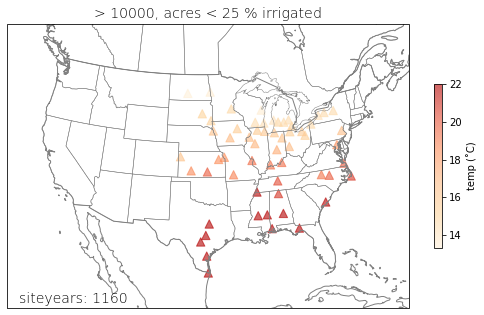

In [15]:
from palettable.colorbrewer.sequential import GnBu_8

# Map out simulation sites
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
mp = ax.scatter(df_wea_summary.lon, df_wea_summary.lat,
                transform=ccrs.PlateCarree(), s=70, marker='^',
                c=df_wea_summary.temp, cmap=OrRd_6.mpl_colormap, 
                vmax=22, alpha=0.6)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'> {int(area*2.47)}, acres < {irri} % irrigated',
             fontweight='light', fontsize=14)
ax.text(-108, 22, f'siteyears: {df_siteyears.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=14)
cbat = fig.colorbar(mp, shrink=0.5, label='temp (˚C)')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/map_temp.png', format='png', dpi=800)

In [7]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_control_dympd.yml')
df_extended, df_stuck = parse_mature(df_all)

In [9]:
def fetch_climate(climate_var):
    years = np.arange(1961, 2006)
    sites = df_sites.site
    start_year = 1961

    # Fetch climate data
    mx = np.empty(shape=(len(sites), len(years)))
    for count_site, site in enumerate(sites):
        climate_years = np.empty(len(years))
        climate_years[:] = np.nan

        for count_year, year in enumerate(years):
            climate = df_wea.query(f"(site=='{site}') & (year=={year})")[climate_var]
            if len(climate) == 0:            
                climate = np.nan
            else:
                climate = float(climate)

            climate_years[count_year] = climate
            mx[count_site] = climate_years
    
    return(mx)

In [10]:
mx_temp = fetch_climate('temp')
mx_precip = fetch_climate('precip')

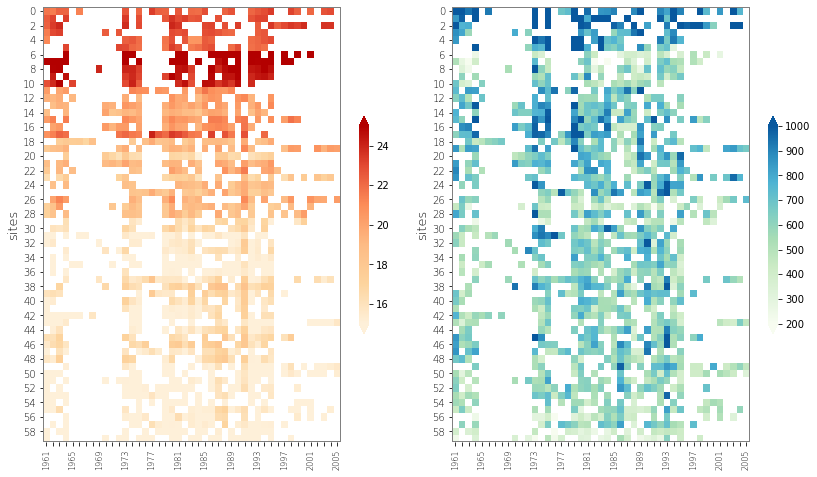

In [16]:
# Customize xtick labels
array_xticks = ['']*45
index_array = np.arange(0,45,4)
array_years = np.arange(1961,2006,4)
for index_a, index_y in zip(index_array, range(len(array_years))):
    array_xticks[index_a] = array_years[index_y]

# Visualize
fig = plt.figure(figsize=(14,8))    
ax1 = fig.add_subplot(1,2,1)
hm1 = sns.heatmap(mx_temp, cmap=OrRd_6.mpl_colormap,
                 cbar_kws={'shrink': 0.5, 'extend': 'both'},
                 vmin=15, vmax=25)
hm1.axhline(y = 0, color='grey',linewidth=2)
hm1.axhline(y = mx_temp.shape[0], color='grey', linewidth=2)
hm1.axvline(x = 0, color='grey', linewidth=2)
hm1.axvline(x = mx_temp.shape[1], color='grey', linewidth=2)

plt.xticks(np.arange(0.5, 45.5, 1), fontweight='light', fontsize=11)
plt.yticks(fontweight='light', fontsize=10, rotation=0)
ax1.set_xticklabels(array_xticks, fontsize=8, fontweight='light', rotation=90)
ax1.set_ylabel('sites', fontweight='light', size=13)

ax2 = fig.add_subplot(1,2,2)
hm2 = sns.heatmap(mx_precip, cmap=GnBu_8.mpl_colormap,
                 cbar_kws={'shrink': 0.5, 'extend': 'both'},
                 vmin=200, vmax=1000)
hm2.axhline(y = 0, color='grey',linewidth=2)
hm2.axhline(y = mx_precip.shape[0], color='grey', linewidth=2)
hm2.axvline(x = 0, color='grey', linewidth=2)
hm2.axvline(x = mx_precip.shape[1], color='grey', linewidth=2)

plt.xticks(np.arange(0.5, 45.5, 1), fontweight='light', fontsize=11)
plt.yticks(fontweight='light', fontsize=10, rotation=0)
ax2.set_xticklabels(array_xticks, fontsize=8, fontweight='light', rotation=90)
ax2.set_ylabel('sites', fontweight='light', size=13)

fig.subplots_adjust(wspace=0.1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_temp_precip.png', format='png', dpi=800)